In [1]:
!pip -q install pyshp
!pip -q install influxdb
!pip -q install shapely
!pip -q install ipyleaflet
!pip -q install plotly

In [2]:
import shapefile
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import time
import os
import numpy as np
import tarfile
from six.moves import urllib
import json
from influxdb import DataFrameClient
from dotenv import load_dotenv
from shapely.geometry import Point, Polygon
from ipyleaflet import Map, GeoJSON, basemaps, Polyline, Heatmap
import requests
from datetime import datetime, timedelta
from scipy.stats import gaussian_kde
from scipy import stats
%matplotlib inline

load_dotenv()

In [4]:
def rm_outside_polygon(res_pd_frame,polygon):
    res_pd_frame_1 = res_pd_frame[['lon','lat','sensor_id']]
    res_pd_frame_2 = res_pd_frame_1.reset_index()
    res_pd_frame_3 = res_pd_frame_2.drop(columns=['index'])
    res_pd_frame4 = res_pd_frame_3.drop_duplicates()
    res_pd_frame4["polygon1"] = res_pd_frame4.apply(lambda row: Polygon(poly).intersects(Point(row["lon"], row["lat"])), axis = 1)
    res_pd_frame5 = res_pd_frame4.drop(res_pd_frame4[res_pd_frame4["polygon1"]].index)
    res_pd_frame = res_pd_frame[~res_pd_frame.sensor_id.isin(res_pd_frame5.sensor_id)]     
    return res_pd_frame

In [5]:
#sf = shapefile.Reader("landkreise-in-germany.shp") # This is Göttingen
#s = sf.shape(0)

sf = shapefile.Reader("bundesland.shp") # Complete germany, 16 shapes for each bundesland
s = sf.shape(3) # Baden-Württemberg
poly = Polygon(s.points)  # Convert to polygon to use shapely function point.within(polygon)

geo_json = GeoJSON(data=s.__geo_interface__, style = {'color': 'red', 'opacity':1, 'weight':1.9, 'dashArray':'9', 'fillOpacity':0.1})

In [6]:
def main(host=os.getenv("HOST"), port=os.getenv("PORT"), rectangle=[0,0,0,0],time_range=["",""],limit=100):
    """Instantiate the connection to the InfluxDB client."""
    user = os.getenv("USER")
    password = os.getenv("PASSWORD")
    dbname = os.getenv("DB")
    protocol = 'line'

    client = DataFrameClient(host, port, user, password, dbname, ssl=True, verify_ssl=True)

    bind_params = {
        "start_time_epoch": time_range[0],
        "end_time_epoch": time_range[1]
    }
    measurement = "temperature, humidity, lat, lon, sensor_id"
    
    query = f"select {measurement} from sensor where \
                     time > $start_time_epoch AND \
                     time < $end_time_epoch AND \
                     lon > {rectangle[0]} AND \
                     lon < {rectangle[2]} AND \
                     lat > {rectangle[1]} AND \
                     lat < {rectangle[3]} \
                     limit {limit}"
                
    res=client.query(query, bind_params=bind_params)
    return res

In [7]:
m = Map(center=(48.7,9.8,0 ), zoom=8, basemap=basemaps.Hydda.Full)
m.add_layer(geo_json)

## Change the 'start_date' & 'date_to_end_query' for changing the time duration of query

In [8]:
start_date = datetime(2017, 1, 2)
end_date = start_date + timedelta(hours=1)

date_to_start_query = start_date
date_to_end_query = datetime(2017, 1, 3, 0, 0, 0)

appended_res_pd_frame_plot_timeindex = []
appended_drop = []

j = 0
number = 5
while number >= 5:
    start_time = time.time()
    
    time_range=[start_date.strftime("%Y-%m-%dT%H:%M:%SZ"),end_date.strftime("%Y-%m-%dT%H:%M:%SZ")]
    print(time_range)
    
    res=main(rectangle=s.bbox,time_range=time_range,limit=10000)
    
    res_pd_frame=rm_outside_polygon(res['sensor'],poly)
    
    if 'temperature' in res_pd_frame.keys():
            res_pd_frame.dropna(subset=['temperature'],inplace = True)
     
    if 'humidity' in res_pd_frame.keys():
            res_pd_frame.dropna(subset=['humidity'],inplace = True)
            
    res_pd_frame_drop = res_pd_frame.drop(['lat', 'lon'], axis = 1)
    
    appended_drop.append(res_pd_frame_drop)  
        
    
    start_date=end_date
    end_date=start_date + timedelta(hours=1)
    print("--- %s seconds ---" % (time.time() - start_time))
    
    if start_date == date_to_end_query: 
        break

temp_humi = pd.concat(appended_drop)
temp_humi


['2017-01-02T00:00:00Z', '2017-01-02T01:00:00Z']


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



--- 1.580540418624878 seconds ---
['2017-01-02T01:00:00Z', '2017-01-02T02:00:00Z']
--- 1.399207353591919 seconds ---
['2017-01-02T02:00:00Z', '2017-01-02T03:00:00Z']
--- 1.3452394008636475 seconds ---
['2017-01-02T03:00:00Z', '2017-01-02T04:00:00Z']
--- 1.7886393070220947 seconds ---
['2017-01-02T04:00:00Z', '2017-01-02T05:00:00Z']
--- 1.372995376586914 seconds ---
['2017-01-02T05:00:00Z', '2017-01-02T06:00:00Z']
--- 1.3395817279815674 seconds ---
['2017-01-02T06:00:00Z', '2017-01-02T07:00:00Z']
--- 1.3455517292022705 seconds ---
['2017-01-02T07:00:00Z', '2017-01-02T08:00:00Z']
--- 1.3548359870910645 seconds ---
['2017-01-02T08:00:00Z', '2017-01-02T09:00:00Z']
--- 1.445237636566162 seconds ---
['2017-01-02T09:00:00Z', '2017-01-02T10:00:00Z']
--- 1.4575750827789307 seconds ---
['2017-01-02T10:00:00Z', '2017-01-02T11:00:00Z']
--- 1.4407784938812256 seconds ---
['2017-01-02T11:00:00Z', '2017-01-02T12:00:00Z']
--- 1.4982728958129883 seconds ---
['2017-01-02T12:00:00Z', '2017-01-02T13:00:00

,temperature,humidity,sensor_id
2017-01-02 00:00:15.029154048+00:00,-3.6,99.9,160
2017-01-02 00:00:15.064538112+00:00,25.6,23.2,342
2017-01-02 00:00:15.122033920+00:00,-2.3,79.7,256
2017-01-02 00:00:15.187874048+00:00,-1.6,80.7,131
2017-01-02 00:00:15.704782080+00:00,-0.5,78.5,298
...,...,...,...
2017-01-02 23:59:51.140034048+00:00,1.2,82.1,340
2017-01-02 23:59:52.749534976+00:00,2.7,76.5,204
2017-01-02 23:59:54.114763008+00:00,1.3,85.2,224
2017-01-02 23:59:55.835403008+00:00,2.3,64.4,288


In [9]:
temp_humidity = temp_humi.drop(['sensor_id'], axis=1)
temp_humidity

,temperature,humidity
2017-01-02 00:00:15.029154048+00:00,-3.6,99.9
2017-01-02 00:00:15.064538112+00:00,25.6,23.2
2017-01-02 00:00:15.122033920+00:00,-2.3,79.7
2017-01-02 00:00:15.187874048+00:00,-1.6,80.7
2017-01-02 00:00:15.704782080+00:00,-0.5,78.5
...,...,...
2017-01-02 23:59:51.140034048+00:00,1.2,82.1
2017-01-02 23:59:52.749534976+00:00,2.7,76.5
2017-01-02 23:59:54.114763008+00:00,1.3,85.2
2017-01-02 23:59:55.835403008+00:00,2.3,64.4


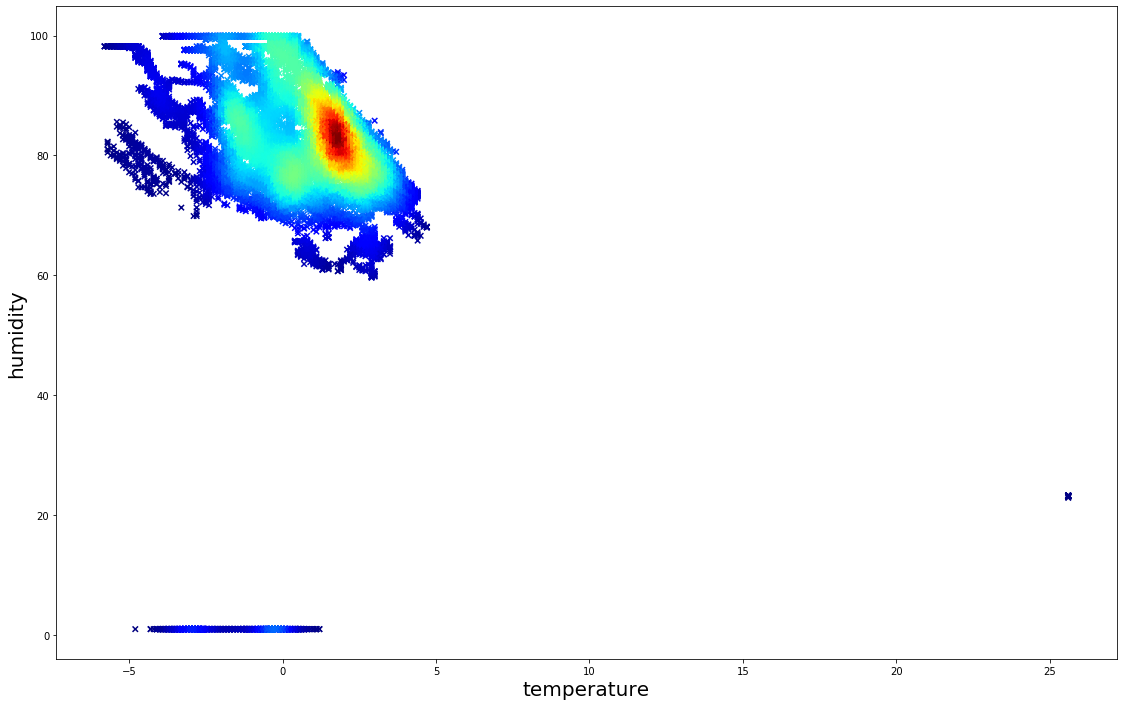

In [10]:
plt.rcParams["figure.figsize"] = (19, 12)
x = temp_humidity.temperature
y = temp_humidity.humidity

# Calculate the point density 
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=30, edgecolor='',marker = "x", cmap=plt.cm.jet)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

plt.xlabel('temperature', fontsize=20)
plt.ylabel('humidity', fontsize=20)
plt.show()

# Z-score (Standard Deviation)

In [11]:
temp_humidity_drop_outliers = temp_humidity[(np.abs(stats.zscore(temp_humidity)) < 3).all(axis=1)]
temp_humidity_drop_outliers

,temperature,humidity
2017-01-02 00:00:15.029154048+00:00,-3.6,99.9
2017-01-02 00:00:15.122033920+00:00,-2.3,79.7
2017-01-02 00:00:15.187874048+00:00,-1.6,80.7
2017-01-02 00:00:15.704782080+00:00,-0.5,78.5
2017-01-02 00:00:15.819762944+00:00,0.5,65.6
...,...,...
2017-01-02 23:59:51.140034048+00:00,1.2,82.1
2017-01-02 23:59:52.749534976+00:00,2.7,76.5
2017-01-02 23:59:54.114763008+00:00,1.3,85.2
2017-01-02 23:59:55.835403008+00:00,2.3,64.4


In [12]:
z = np.abs(stats.zscore(temp_humidity))
print(z)

[[ 1.86573946  0.94812706]
 [12.25370138  2.58186503]
 [ 1.23713421  0.01845509]
 ...
 [ 0.50361877  0.27158359]
 [ 0.98716126  0.6857024 ]
 [ 0.50361877  0.0828878 ]]


In [13]:
z.shape

(36323, 2)

In [14]:
threshold = 3
print(np.where(z > 3))

(array([    1,    10,    23, ..., 36266, 36286, 36307]), array([0, 1, 1, ..., 1, 1, 1]))


In [15]:
print(z[1][0])

12.253701380584944


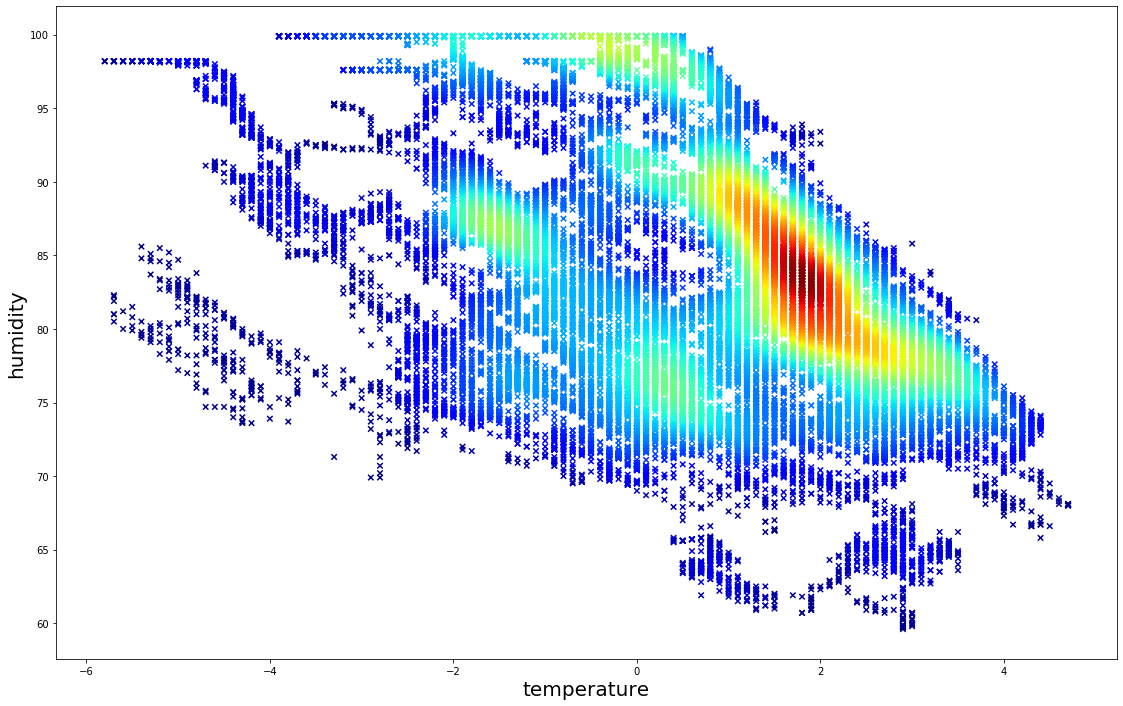

In [16]:
#plotting with z-score
plt.rcParams["figure.figsize"] = (19, 12)
x = temp_humidity_drop_outliers.temperature
y = temp_humidity_drop_outliers.humidity

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=30, edgecolor='',marker = "x", cmap=plt.cm.jet)
plt.xlabel('temperature', fontsize=20)
plt.ylabel('humidity', fontsize=20)
plt.show()

# IQR score, IQR = Q3 − Q1

In [17]:
Q1 = temp_humidity.quantile(0.25)
Q3 = temp_humidity.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

temperature     2.8
humidity       13.6
dtype: float64


In [18]:
df = (temp_humidity < (Q1 - 1.5 * IQR)) |(temp_humidity > (Q3 + 1.5 * IQR))
df

,temperature,humidity
2017-01-02 00:00:15.029154048+00:00,False,False
2017-01-02 00:00:15.064538112+00:00,True,True
2017-01-02 00:00:15.122033920+00:00,False,False
2017-01-02 00:00:15.187874048+00:00,False,False
2017-01-02 00:00:15.704782080+00:00,False,False
...,...,...
2017-01-02 23:59:51.140034048+00:00,False,False
2017-01-02 23:59:52.749534976+00:00,False,False
2017-01-02 23:59:54.114763008+00:00,False,False
2017-01-02 23:59:55.835403008+00:00,False,False


In [19]:
temp_humidity_rm_out = df[-df.temperature]
temp_humidity_rm_out = temp_humidity_rm_out[-temp_humidity_rm_out.humidity]
temp_humidity_rm_out

,temperature,humidity
2017-01-02 00:00:15.029154048+00:00,False,False
2017-01-02 00:00:15.122033920+00:00,False,False
2017-01-02 00:00:15.187874048+00:00,False,False
2017-01-02 00:00:15.704782080+00:00,False,False
2017-01-02 00:00:15.819762944+00:00,False,False
...,...,...
2017-01-02 23:59:51.140034048+00:00,False,False
2017-01-02 23:59:52.749534976+00:00,False,False
2017-01-02 23:59:54.114763008+00:00,False,False
2017-01-02 23:59:55.835403008+00:00,False,False


In [20]:
temp_humidity_valid = temp_humidity[~((temp_humidity < (Q1 - 1.5 * IQR)) |(temp_humidity > (Q3 + 1.5 * IQR))).any(axis=1)]
temp_humidity_valid

,temperature,humidity
2017-01-02 00:00:15.029154048+00:00,-3.6,99.9
2017-01-02 00:00:15.122033920+00:00,-2.3,79.7
2017-01-02 00:00:15.187874048+00:00,-1.6,80.7
2017-01-02 00:00:15.704782080+00:00,-0.5,78.5
2017-01-02 00:00:15.819762944+00:00,0.5,65.6
...,...,...
2017-01-02 23:59:51.140034048+00:00,1.2,82.1
2017-01-02 23:59:52.749534976+00:00,2.7,76.5
2017-01-02 23:59:54.114763008+00:00,1.3,85.2
2017-01-02 23:59:55.835403008+00:00,2.3,64.4


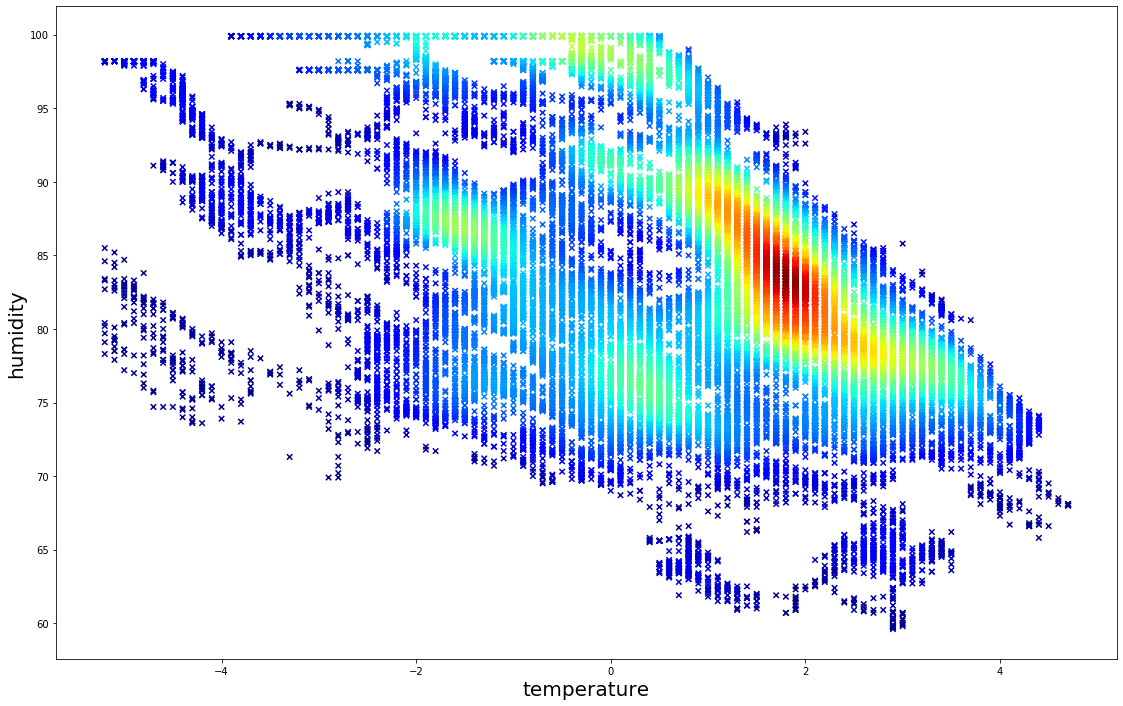

In [21]:
# plotting with IQR-score
plt.rcParams["figure.figsize"] = (19, 12)
x = temp_humidity_valid.temperature
y = temp_humidity_valid.humidity

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=30, edgecolor='',marker = "x", cmap=plt.cm.jet)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

plt.xlabel('temperature', fontsize=20)
plt.ylabel('humidity', fontsize=20)
plt.show()

# Isolation forest

In [22]:
from sklearn.ensemble import IsolationForest

In [23]:
iso_forest = IsolationForest(n_estimators=300, contamination=0.10)
iso_forest = iso_forest.fit(temp_humidity)

/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning:

behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.



In [24]:
isof_outliers = iso_forest.predict(temp_humidity)

/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.



In [25]:
isoF_non_outliers_values = temp_humidity[iso_forest.predict(temp_humidity) == 1]

/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.



In [26]:
isoF_outliers_values = temp_humidity[iso_forest.predict(temp_humidity) == -1]

/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.



In [27]:
isoF_outliers_values

,temperature,humidity
2017-01-02 00:00:15.064538112+00:00,25.6,23.2
2017-01-02 00:00:21.868019968+00:00,-3.9,1.0
2017-01-02 00:00:37.575033088+00:00,-4.6,91.3
2017-01-02 00:00:38.145609984+00:00,-5.8,98.2
2017-01-02 00:00:54.647801088+00:00,-3.7,1.0
...,...,...
2017-01-02 23:56:22.600424960+00:00,-1.2,1.0
2017-01-02 23:57:09.490566912+00:00,-1.3,1.0
2017-01-02 23:57:51.672877056+00:00,-1.3,1.0
2017-01-02 23:58:41.788534016+00:00,-1.3,1.0


In [28]:
isoF_non_outliers_values

,temperature,humidity
2017-01-02 00:00:15.029154048+00:00,-3.6,99.9
2017-01-02 00:00:15.122033920+00:00,-2.3,79.7
2017-01-02 00:00:15.187874048+00:00,-1.6,80.7
2017-01-02 00:00:15.704782080+00:00,-0.5,78.5
2017-01-02 00:00:15.819762944+00:00,0.5,65.6
...,...,...
2017-01-02 23:59:51.140034048+00:00,1.2,82.1
2017-01-02 23:59:52.749534976+00:00,2.7,76.5
2017-01-02 23:59:54.114763008+00:00,1.3,85.2
2017-01-02 23:59:55.835403008+00:00,2.3,64.4


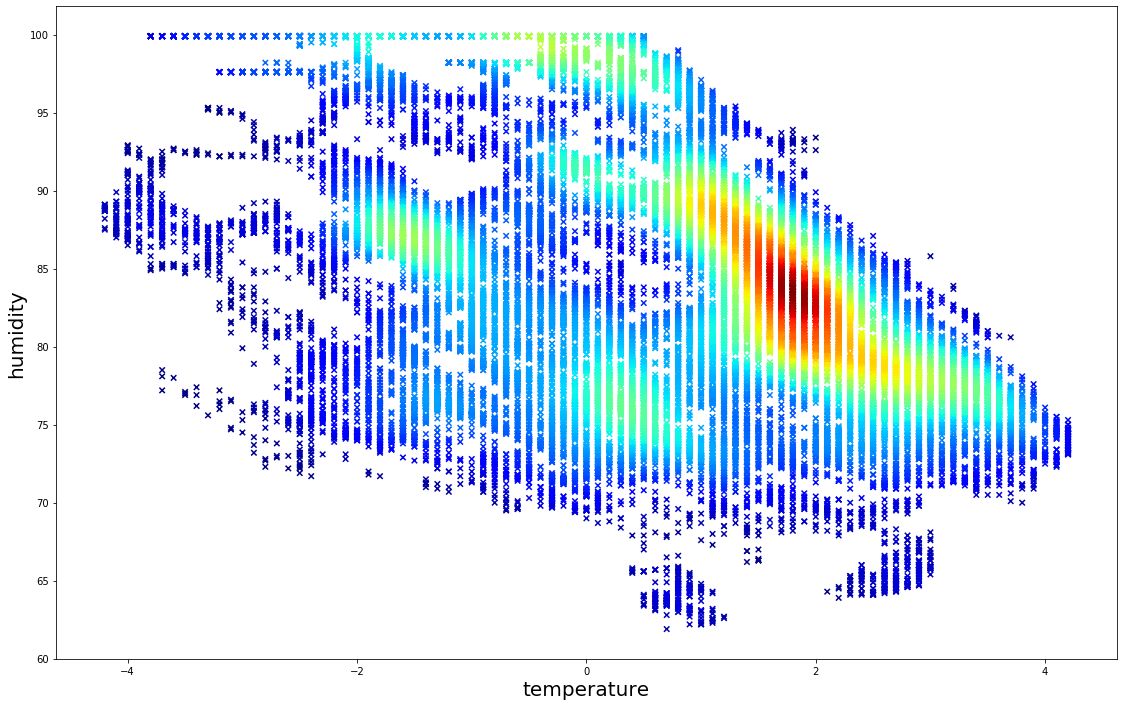

In [29]:
# plotting with isolation forest
plt.rcParams["figure.figsize"] = (19, 12)
x = isoF_non_outliers_values.temperature
y = isoF_non_outliers_values.humidity

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=30, edgecolor='',marker = "x", cmap=plt.cm.jet)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

plt.xlabel('temperature', fontsize=20)
plt.ylabel('humidity', fontsize=20)
plt.show()

# Correlation

In [33]:
isoF_non_outliers_values['temperature'].corr(isoF_non_outliers_values['humidity'])

-0.4571716245396115

In [34]:
corrMatrix = isoF_non_outliers_values.corr()
print (corrMatrix)

             temperature  humidity
temperature     1.000000 -0.457172
humidity       -0.457172  1.000000


# Difference between three outlier detection approaches

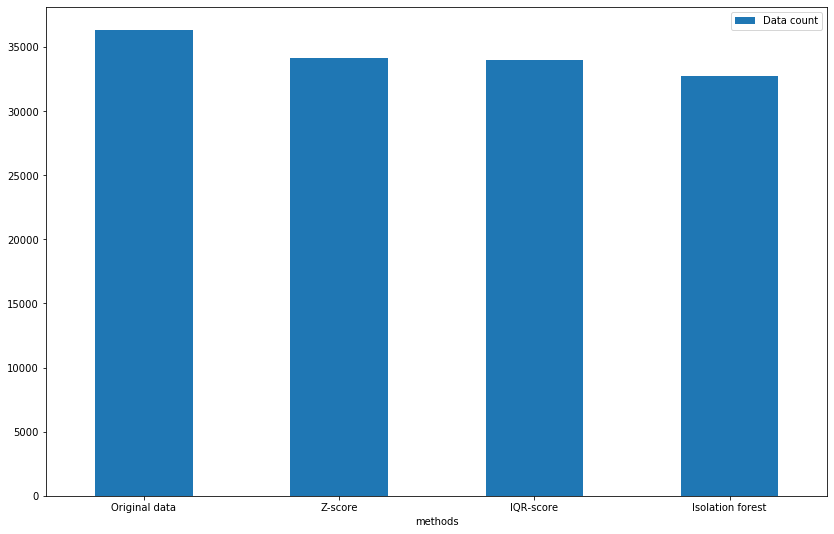

In [35]:
plt.rcParams["figure.figsize"] = (14, 9)
# Original data
x = temp_humidity.temperature
y = temp_humidity.humidity
original = len(temp_humidity.index)

# z-score
x = temp_humidity_drop_outliers.temperature
y = temp_humidity_drop_outliers.humidity
z_score = len(temp_humidity_drop_outliers.index)


# IQR-score
x = temp_humidity_valid.temperature
y = temp_humidity_valid.humidity
iqr_score = len(temp_humidity_valid.index)

# Isolcation forest
x = isoF_non_outliers_values.temperature
y = isoF_non_outliers_values.humidity
iso = len(isoF_non_outliers_values.index)

df = pd.DataFrame({'methods':['Original data', 'Z-score', 'IQR-score', 'Isolation forest'],
                   'Data count':[original, z_score, iqr_score, iso]})
ax = df.plot.bar(x='methods', y='Data count', rot=0)